In [1]:
from processing.polyphony import *
import processing.polyphony as pp 


In [2]:
#output_sequence_len = 0 if not encoder_decoder else >=1

# Data INFO
# ~175K midi files  
# Files could be short melodies, loop compositions or long symphonies or songs
# ~10K midi files in each of the 16 top level subdirectories 
# Considering 300 midi files at present3, at 8 resolution..~ 0.2% Dataset
# Generating a polyphonic monophony music (multiple instruments each following a monophonic melody line independently) or type of contrapuntal 
train_source, val_source, test_source  = sample_dataset('./lpd_5/all', nsamples=10000, train_size=0.9, val_size=0.2, input_sequence_len=100, output_sequence_len=100, resolution=8, batch_size=128, encoder_decoder=True)

Preparing test dataset...: 100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


In [9]:
train_source = ('lpd_5_batched/train_inputs', 'lpd_5_batched/train_outputs')
music_loader = load_music_batches(*train_source, encoder_decoder=True)
steps = len(os.listdir(train_source[0]))-1
steps



13230

In [10]:
val_source = ('lpd_5_batched/val_inputs', 'lpd_5_batched/val_outputs')
val_music_loader = load_music_batches(*val_source, encoder_decoder=True)
val_steps = len(os.listdir(val_source[0]))-1
val_steps

3424

In [11]:
from models import transformer_encoder_decoder
model = transformer_encoder_decoder(music_dim=pp.vocab['last']+1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 time_distributed_2 (TimeDi  (None, None, 100)            212800    ['input_3[0][0]']             
 stributed)                                                                                       
                                                                                                  
 time_distributed_3 (TimeDi  (None, None, 100)            212800    ['input_4[0][0]']       

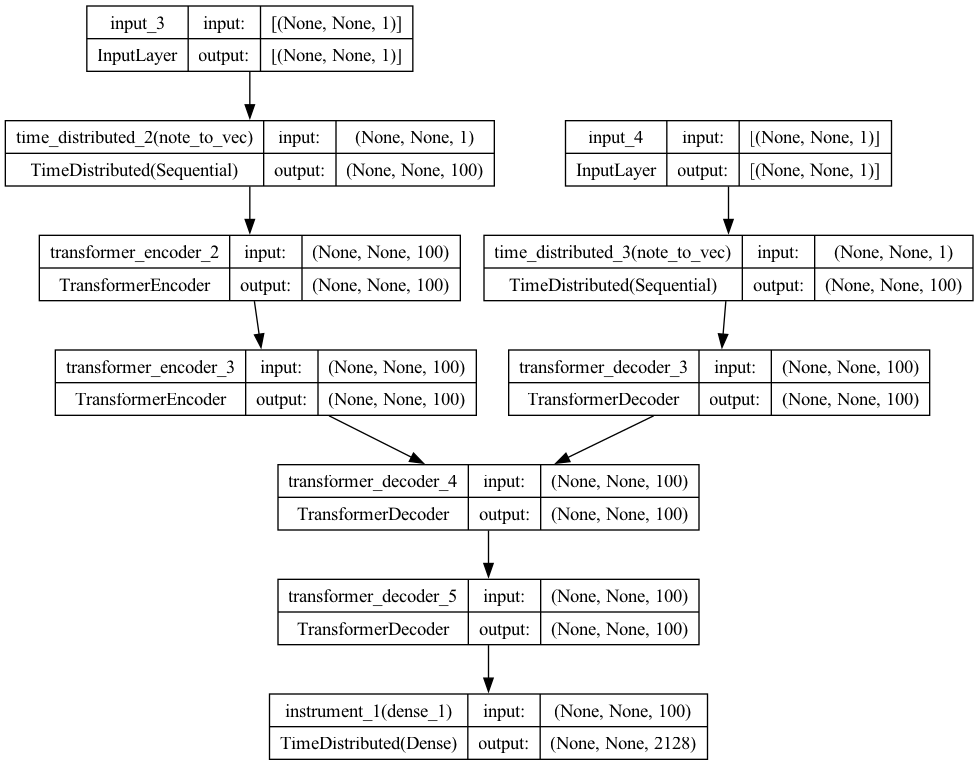

In [12]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [13]:
import tensorflow as tf
import os


class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, model, checkpoint_dir, save_best_only=True):
        super(ModelCheckpoint, self).__init__()
        self.model = model
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if self.save_best_only and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            filepath = os.path.join(self.checkpoint_dir, f"best_model.keras")
            self.model.save(filepath, overwrite=True)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")
        else:
            filepath = os.path.join(self.checkpoint_dir, f"model_epoch_{epoch}.keras")
            self.model.save(filepath, overwrite=True)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")

modelname = "encoder-decoder-transformer-10Ksamples-1instrument-longer-2"
checkpoint_dir = f"./{modelname}-checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = ModelCheckpoint(model, checkpoint_dir)
callbacks_list = [model_checkpoint]   



In [ ]:
history = model.fit(music_loader, steps_per_epoch=steps, validation_data=val_music_loader, validation_steps=val_steps, epochs=50, callbacks=callbacks_list)

In [17]:
modell = tf.keras.models.load_model('encoder-decoder-transformer-10Ksamples-1instrument-longer-2')
modell.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 time_distributed_2 (TimeDi  (None, None, 100)            212800    ['input_3[0][0]']             
 stributed)                                                                                       
                                                                                                  
 time_distributed_3 (TimeDi  (None, None, 100)            212800    ['input_4[0][0]']       

In [16]:
model.save('encoder-decoder-transformer-10Ksamples-1instrument-longer-2')

INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer-2/assets


INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer-2/assets


In [12]:
model.save(modelname)

INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer-2/assets


INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer-2/assets


In [7]:
model = tf.keras.models.load_model(modelname)

In [ ]:
tracks = sample_track('lpd_5/all', nsamples=1000, input_sequence_len=100, resolution=8)

((100, 1), (919, 1))

In [35]:

os.makedirs('./generations_set', exist_ok=True)
os.makedirs('./validation_set', exist_ok=True)

for i in range(15):
    print(f"Sample : {i+1}")
    try:
        x, y = tracks[randint(0, len(tracks)-1)]
        composer = compose_music(music_model=model, cue=x, topn=129, encoder_decoder=True, print_gen=False)
        total_track_length = y.shape[0]
        composition_length = int(0.5*total_track_length)
        TEMPO = 60

        print(f"Composing for {composition_length} time steps at {TEMPO} bpm")
        for _ in range(composition_length):
            composition = next(composer)
         
        print("Composition Done...")


        output_midi_path = f'./generations_set/generated_track_transformer_{i}.mid'
        output_audio_path = f'./generations_set/generated_track_transformer_{i}.wav'

        
        generated_path= make_midi(composition, tempo=TEMPO, output_file=output_midi_path)
        print("Track Done...")
        print("Generated Midi file Done...")

        midi_to_wav(output_midi_path, output_audio_path)
        print("Generated Audio file Done...")



        output_midi_path = f'./validation_set/original_track_transformer_{i}.mid'
        output_audio_path = f'./validation_set/original_track_transformer_{i}.wav'

        original_track = make_midi(composition=y[:composition_length], tempo=TEMPO, output_file=output_midi_path)
        print("Original Track Done...")
        print("Original Midi file Done...")

        midi_to_wav(output_midi_path, output_audio_path)
        print("Original Audio file Done...")

    except Exception as E:
        print(E)
        pass

Sample : 1
Composing for 175 time steps at 60 bpm
Composition Done...
MIDI file saved as: ./generations_set/generated_track_transformer_0.mid
Track Done...
Generated Midi file Done...
Playing ./generations_set/generated_track_transformer_0.mid
MIDI file: ./generations_set/generated_track_transformer_0.mid
Format: 1  Tracks: 2  Divisions: 10080
Track name: Piano
Playing time: ~92 seconds
Notes cut: 0
Notes lost totally: 0
Conversion completed successfully.
Generated Audio file Done...
MIDI file saved as: ./validation_set/original_track_transformer_0.mid
Original Track Done...
Original Midi file Done...
Playing ./validation_set/original_track_transformer_0.mid
MIDI file: ./validation_set/original_track_transformer_0.mid
Format: 1  Tracks: 2  Divisions: 10080
Track name: Piano
Playing time: ~91 seconds
Notes cut: 0
Notes lost totally: 0
Conversion completed successfully.
Original Audio file Done...
Sample : 2
Composing for 135 time steps at 60 bpm
Composition Done...
MIDI file saved as: .

In [34]:
!rm -r ./validation_set/